In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from scipy.ndimage.measurements import label


%matplotlib inline

print('Loaded Successfully')

Loaded Successfully


#### Loading the training datasets

In [2]:
car_images = glob.glob('dataset/vehicles_smallset/cars**/*.jpeg')
noncar_images = glob.glob('dataset/non-vehicles_smallset/notcars**/*.jpeg')
dataset_car= len(car_images)
dataset_noncar=len(noncar_images)
print("Total number of datasets of cars and non-cars")
print(dataset_car,dataset_noncar)

Total number of datasets of cars and non-cars
1196 1125


In [3]:
def plot(car_images,noncar_images):
    fig, axs = plt.subplots(8,8, figsize=(16, 16))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # Step through the list and search for chessboard corners
    for i in np.arange(32):
        img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('car', fontsize=10)
        axs[i].imshow(img)
    for i in np.arange(32,64):
        img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('not a car', fontsize=10)
        axs[i].imshow(img)
    plt.show()

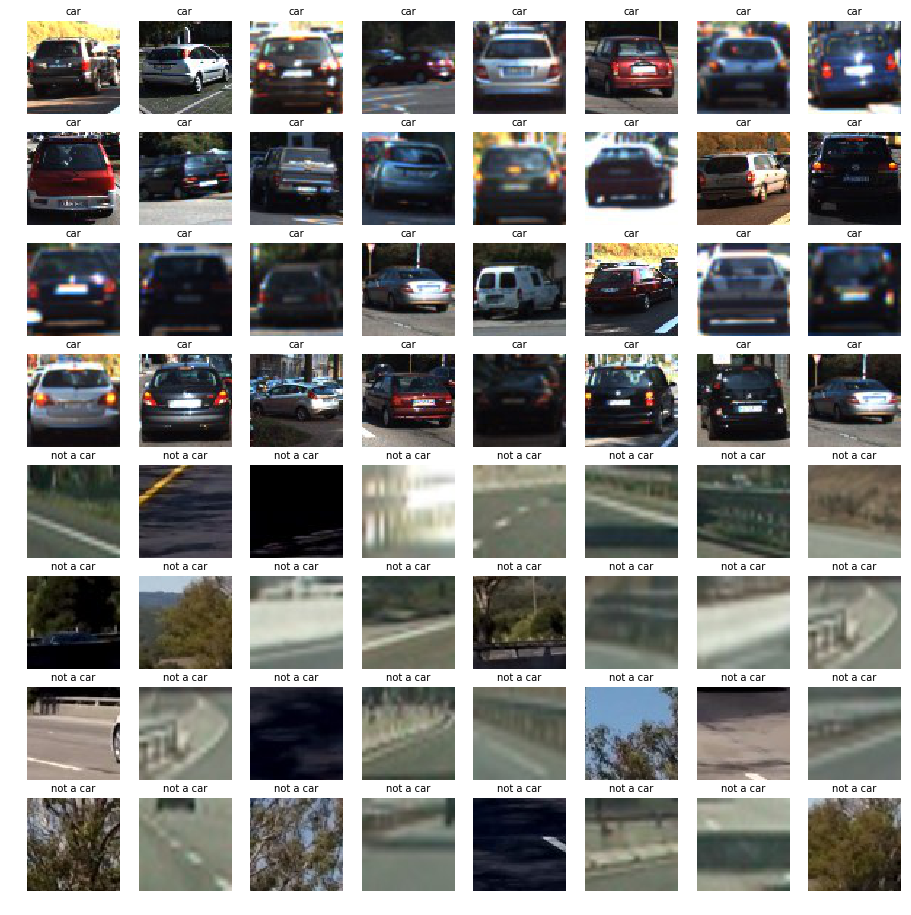

In [4]:
plot(car_images,noncar_images)

In [5]:
# HOG FEATURE EXTRACTION FUNCTION

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
print("Function to convert image to HOG features is created")
print("Apply following arguments in function calling")
print("get_hog_features(image,oreintation,pixels per cell,cell per block,vis='True/False',feature_vector='True/False')")

Function to convert image to HOG features is created
Apply following arguments in function calling
get_hog_features(image,oreintation,pixels per cell,cell per block,vis='True/False',feature_vector='True/False')


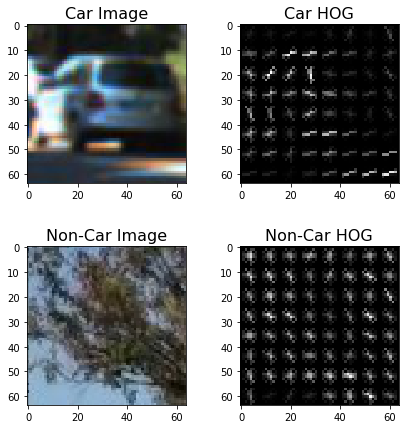

In [6]:
#VISUALIZING THE DATA
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()

#### Reason for Choosing Hog parameters
- colorspace = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb--After trying various combinations only YCrCb combination worked well with the program 
- orient = 9----------Choosed oreientation 9 by trial and error method---other combinations used 11,12,13,8 
- pix_per_cell = 16-------Choosed by trail and error method---Other combinations used 8,4,32.
- cell_per_block = 4--------Choosed Folowing input by trial and error method used 8,2,1,4.
- hog_channel = 1 # Can be 0, 1, 2, or "ALL"----Value Selected by Trial And Error Method.

In [7]:
# FUNCTION TO EXTRACT ALL FEATURES=[HOG,HISTOGRAM,SPATIAL]
#NOTE FUNCTIONS FOR HISTOGRAM AND SPATIAL CREATED BELOW
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [8]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [10]:
#DATA SET GENERATION 
colorspace = "YCrCb" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16
cell_per_block = 4
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
car_features=[]
notcar_features=[]
t=time.time()
for image in car_images:
    img=mpimg.imread(image)
    features =single_img_features(img, color_space=colorspace, spatial_size=(32, 32),
                        hist_bins=32, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    car_features.append(features)
    

    
for image in noncar_images:
    img=mpimg.imread(image)
    features=single_img_features(img, color_space=colorspace, spatial_size=(32, 32),
                        hist_bins=32, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    notcar_features.append(features)
    
t2=time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

15.23 Seconds to extract features...


In [11]:
#TRAINING AND TESTING DATA GENERATION
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))



# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
data_train_data=(X_train,y_train)
data_test_data=(X_test,y_test)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 3312


In [12]:
#TRAINING THE CLASSIFIER USING SVM -SUPPORT VECTOR MACHINES
# Use a linear SVC 
svc =svm.SVC(C=0.0001,kernel='linear')
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    

8.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9871
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  0.  1.]
For these 20 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  0.  1.]
0.15531 Seconds to predict 20 labels with SVC


In [19]:
#FUNCTIONS FOR SEARCHING THE CARS IN THE IMAGE
def search_windows(img, windows, svc, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features =single_img_features(test_img, color_space=colorspace, spatial_size=(32, 32),
                        hist_bins=32, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
        #5) Scale extracted features to be fed to classifier
        feature=np.array(features).reshape(1, -1)
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        
            #7) If positive (prediction == 1) then save the window
        if prediction==1:
            if svc.decision_function(test_features) >.70:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [14]:
# FUNCTION FOR DRAWING THE BOXES
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [15]:
#SLIDING WINDOW FUNCTION
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [16]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block =4 # HOG cells per block
hog_channel = 1# Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 650] # Min and max in y to search in slide_window()


#### Sliding Window of Range[(128,128),(96,96),(64,64) were used to get more stronger prediction from classifier in order to differentiate cars and draw boxes accordingly]

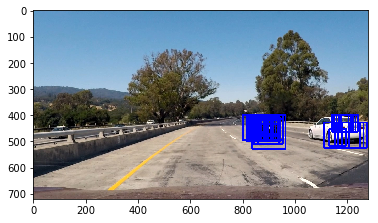

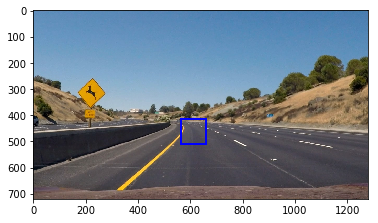

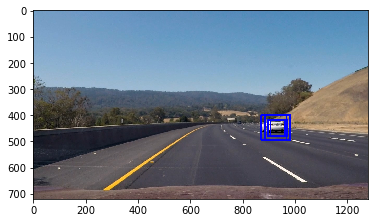

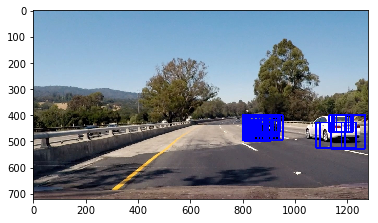

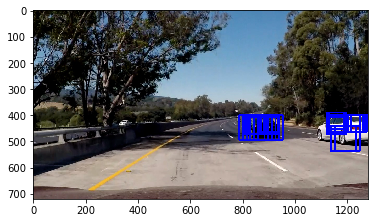

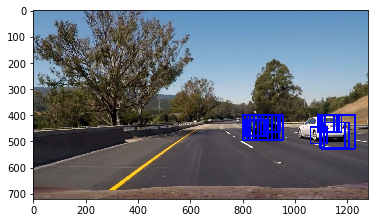

In [20]:
for images in glob.glob('test_images/test*.jpg'):
    img=mpimg.imread(images)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.70, 0.70))
    windows+= slide_window(img, x_start_stop=[32, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.85))
    windows+= slide_window(img, x_start_stop=[412, 1280], y_start_stop=[390,540], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))


    hot_windows=search_windows(img, windows, svc, X_scaler, color_space=colorspace, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    plt.imshow(window_img)
    plt.show()


##### Heat Map

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [22]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [32]:
from collections import deque
global heatmaps
heatmaps= deque(maxlen = 8)



def draw_heatmaps(img):
    
    
    
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.70, 0.70))
    windows+= slide_window(img, x_start_stop=[32, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.85))
    windows+= slide_window(img, x_start_stop=[412, 1280], y_start_stop=[390,540], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    hot_windows=search_windows(img, windows, svc, X_scaler, color_space=colorspace, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    heat = np.zeros_like(image[:,:,1]).astype(np.float)
   
    
    heat = add_heat(heat,hot_windows)
    heatmaps.append(heat)
    combined = sum(heatmaps)
    
    heat = apply_threshold(combined,1)


    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img,heatmap

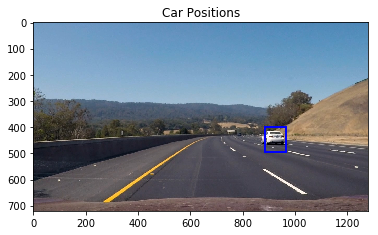

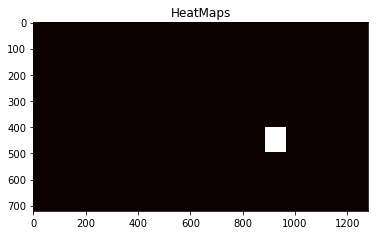

In [30]:
image=mpimg.imread('test_images/test3.jpg')
draw_img,heatmap=draw_heatmaps(image)
plt.figure(figsize=(6,4))
plt.imshow(draw_img)
plt.title('Car Positions')
plt.figure(figsize=(6,4))
plt.imshow(heatmap, cmap='hot')
plt.title('HeatMaps')
plt.show()

In [28]:
def process_video(img):
    draw_img,heatmap=draw_heatmaps(img)
    return draw_img
    

In [36]:
from moviepy.editor import VideoFileClip
video_output = 'test_results.mp4'
video = VideoFileClip("test_video.mp4")
video = video.fl_image(process_video) 
video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_results.mp4
[MoviePy] Writing video test_results.mp4




  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

  3%|██▏                                                                                | 1/39 [00:10<06:23, 10.10s/it]

  5%|████▎                                                                              | 2/39 [00:19<06:05,  9.87s/it]

  8%|██████▍                                                                            | 3/39 [00:29<05:52,  9.79s/it]

 10%|████████▌                                                                          | 4/39 [00:38<05:35,  9.59s/it]

 13%|██████████▋                                                                        | 5/39 [00:47<05:22,  9.49s/it]

 15%|████████████▊                                                                      | 6/39 [00:56<05:10,  9.39s/it]

 18%|██████████████▉                                                                    | 7/39 [01:05<04:59,  9.35s/it]

 21%|█████████████████        

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_results.mp4 



In [33]:
from moviepy.editor import VideoFileClip
video_output = 'project_results.mp4'
video = VideoFileClip("project_video.mp4")
video = video.fl_image(process_video) 
video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_results.mp4
[MoviePy] Writing video project_results.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:53:29<00:08,  8.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_results.mp4 

